In [1]:
#import packages

import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sea
from sklearn.metrics import r2_score, mean_squared_error
from catboost import CatBoostRegressor

In [2]:
def predict__values(model, x_values):
    y_pred = model.predict(x_values)
    return np.expm1(y_pred)

In [3]:
def cross_validate_model(model, x, y):
    fold_scores = cross_val_score(model, x, y, cv=5, scoring="neg_root_mean_squared_error", n_jobs = -1)
    print("Score : ", np.mean(fold_scores))

In [18]:
def evaluate_model(model, x, y, split, random_state=42):
    x_train_eval, x_valid_eval, y_train_eval, y_valid_eval = train_test_split(x, y, test_size=split, random_state=random_state)
    model.fit(x_train_eval, y_train_eval) 
    y_pred_eval = model.predict(x_valid_eval)
    rmse = np.sqrt(mean_squared_error(y_valid_eval, y_pred_eval))
    r_squared = r2_score(y_valid_eval, y_pred_eval)
    return pd.DataFrame([{
        "RMSE" : rmse,
        "R2" : r_squared
    }])

In [5]:
# read input files

train = pd.read_csv('train.csv', index_col='id')
test = pd.read_csv('test.csv')

<Axes: >

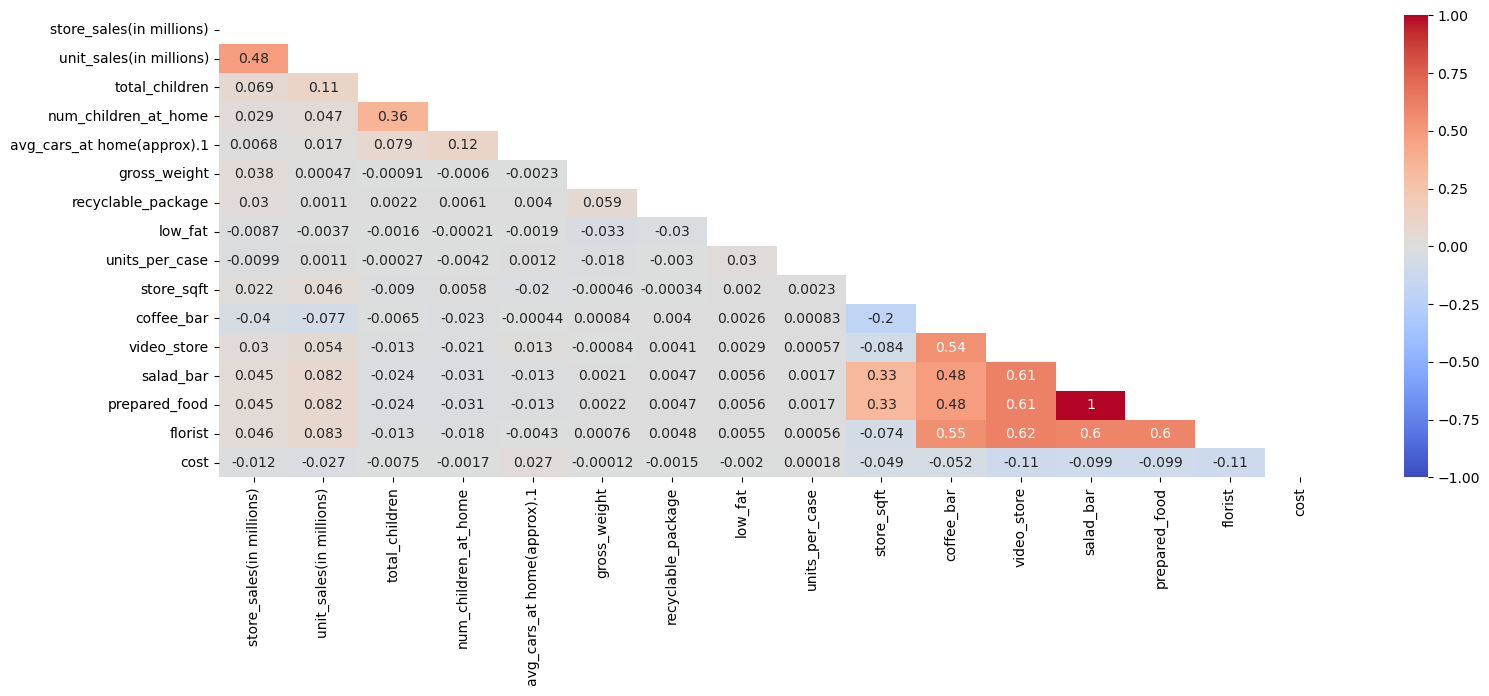

In [6]:
correlation_matrix = train.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
plt.figure(figsize=(18, 6))
sea.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', vmin=-1, vmax=1)

In [7]:
x_train = train.drop(["cost", "prepared_food"], axis=1)
x_test = test.drop(["id", "prepared_food"], axis=1)

y_train = train[["cost"]]

In [8]:
y_train = np.log1p(y_train)

In [9]:
cat_model = CatBoostRegressor(verbose=0)
print("Score : ", cross_validate_model(cat_model, x_train, y_train["cost"]))

KeyboardInterrupt: 

In [10]:
x_train['store_options'] = x_train[['coffee_bar', 'video_store', 'salad_bar', 'florist']].sum(axis=1)
x_test['store_options'] = x_test[['coffee_bar', 'video_store', 'salad_bar', 'florist']].sum(axis=1)

In [11]:
x_train["children_ratio"] = x_train["total_children"]/x_train["num_children_at_home"]
x_train["children_ratio"] = x_train["children_ratio"].replace([np.inf, -np.inf], 10)
x_train = x_train.fillna(0)

x_test["children_ratio"] = x_test["total_children"]/x_test["num_children_at_home"]
x_test["children_ratio"] = x_test["children_ratio"].replace([np.inf, -np.inf], 10)
x_test = x_test.fillna(0)

In [12]:
x_train["units_per_sqft"] = x_train["unit_sales(in millions)"]/x_train["store_sqft"]

x_test["units_per_sqft"] = x_test["unit_sales(in millions)"]/x_test["store_sqft"]

In [13]:
x_train.head()

,store_sales(in millions),unit_sales(in millions),total_children,num_children_at_home,avg_cars_at home(approx).1,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,coffee_bar,video_store,salad_bar,florist,store_options,children_ratio,units_per_sqft
id,,,,,,,,,,,,,,,,,
0,8.61,3.0,2.0,2.0,2.0,10.30,1.0,0.0,32.0,36509.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000082
1,5.00,2.0,4.0,0.0,3.0,6.66,1.0,0.0,1.0,28206.0,1.0,0.0,0.0,0.0,1.0,10.0,0.000071
2,14.08,4.0,0.0,0.0,3.0,21.30,1.0,0.0,26.0,21215.0,1.0,0.0,0.0,0.0,1.0,0.0,0.000189
3,4.02,3.0,5.0,0.0,0.0,14.80,0.0,1.0,36.0,21215.0,1.0,0.0,0.0,0.0,1.0,10.0,0.000141
4,2.13,3.0,5.0,0.0,3.0,17.00,1.0,1.0,20.0,27694.0,1.0,1.0,1.0,1.0,4.0,10.0,0.000108


In [ ]:
cat_model = CatBoostRegressor(verbose=0)
print("Score : ", cross_validate_model(cat_model, x_train, y_train["cost"]))

In [ ]:
param_dist = {
    'iterations': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'depth': [4, 6, 8, 10],
    'l2_leaf_reg': [1, 3, 5, 7]
}

clf = RandomizedSearchCV(
    estimator = CatBoostRegressor(verbose=0),
    param_distributions = param_dist, 
    cv = 5,
    n_iter = 50,
    verbose = 2,
    n_jobs = -1,
    scoring="neg_root_mean_squared_error"
)
clf.fit(x_train, y_train['cost'])
print("best_score : ", clf.best_score_)
print("best_params : ", clf.best_params_)

In [19]:
best_model = CatBoostRegressor(
    learning_rate = 0.1,
    l2_leaf_reg = 7,
    iterations = 300,
    depth = 8,
    verbose = 0
)

In [20]:
evaluate_model(best_model, x_train, y_train["cost"], 0.2)

,RMSE,R2
0,0.297829,0.118041


In [21]:
y_pred = predict__values(best_model, x_test)
final_df = pd.DataFrame( y_pred, columns=['cost'])
final_df.insert(0, 'id', test['id'])
final_df.shape

(240224, 2)

In [22]:
final_df.to_csv('UOM_190215X_CatBoost.csv', index=False)